## Introduction

At times tree algorithms are recursive. I had trouble in following few of them while dealing with AVL tree and Splay tree. So I thought of putting together this notebook which not only implements these algorithms recursive but also augments operations with scalable vector graphics diagram of the tree before and after manipulation. 

In [20]:
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout
import networkx as nx
import os
import pydot_ng as pydot
import pathlib

OUTPUT_DIR = os.path.join(os.getcwd(),'img')
from IPython.display import SVG, display

def show_svg(img):
    display(SVG(url='file://%s/%s' % (OUTPUT_DIR, img)))

### Implement first, last, after & before for binary search tree

* first(): Return the position containing the least key, or None if the tree is empty.
* last(): Return the position containing the greatest key, or None if empty tree.
* before(p): Return the position containing the greatest key that is less than that of position p (i.e., the position that would be visited immediately before p in an inorder traversal), or None if p is the first position.
* after(p): Return the position containing the least key that is greater than that of position p (i.e., the position that would be visited immediately after p in an inorder traversal), or None if p is the last position.

In [12]:
class IllegalArgumentError(ValueError):
    pass

# Generates visualization of binary tree when nodes and edges list are provided
# Ordering is assumed to be level ordering
def draw_tree(svg_file, tree=None, nodes=[], edges=[]):
    if tree is None and len(nodes) == 0 and len(edges) == 0:
        raise IllegalArgumentError('Either root node or the list of nodes & edges need to be provided')
    if tree is not None:
        nodes, edges = tree.level_order_traversal()
    dot_g = pydot.Dot(graph_type='digraph', rankdir="TB", compound='true')
    g = nx.DiGraph()
    pydot_nodes = {}
        
    for i, n in enumerate(nodes):
        g.add_node(i, data={'value': n})
        
    for e in edges:
        g.add_edge(e[0], e[1])
    
    for node in g.nodes(data=True):
        n = pydot.Node(node[0] , label=node[1]['data']['value'], fillcolor="skyblue", fontsize=8, shape="circle", style='filled')
        pydot_nodes[node[0]] = n
        dot_g.add_node(n)
        
    for index, edge in enumerate(g.edges()):
        src_node = pydot_nodes[edge[0]]
        dst_node = pydot_nodes[edge[1]]
        color = 'red' if nodes[edge[0]] < nodes[edge[1]] else 'green'
        label = 'R' if nodes[edge[0]] < nodes[edge[1]] else 'L'
        dot_g.add_edge(pydot.Edge(src_node, dst_node, color=color, label=label, fontsize=10))

    pathlib.Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True) 
    dot_g.write_svg(os.path.join(OUTPUT_DIR, svg_file))
    

In [15]:
# Binary search tree
class Node:
    def __str__(self):
        return str(self.value)
    def __init__(self, value, left=None, right=None):
        self.value = value
        self.left = left
        self.right = right

class Tree:
    # Build tree from level order - nodes & eddes need to be provided
    # If the tree is already build, it can accept the root node
    def __init__(self, nodes=[], edges=[], root=None):
        node_lookup = {}
        # If parameter root is not null then assign that value to intsnace variable
        # Skip the rest of the statements
        self.root = root
        if root is None: # edges and nodes need to provided in this scase
            for i, n in enumerate(nodes):
                node_lookup[i] = Node(value=n)
            for e in edges:
                src, dst = node_lookup[e[0]], node_lookup[e[1]]
                if src.value > dst.value:
                    src.left = dst
                else:
                    src.right = dst
            if len(nodes) > 0:
                self.root = node_lookup[0]

    def inorder(self, root=None, result=[], level=0):
        if level == 0:
            result = []
            if root is None:
                root = self.root
        if root is None:
            return result
        if root.left is not None:
            self.inorder(root=root.left, result=result, level=level + 1)
        result.append(root.value)
        if root.right is not None:
            self.inorder(root=root.right, result=result, level=level + 1)
        return result

    def preorder(self, root=None, result=[], level=0):
        if level == 0:
            result = []
            if root is None:
                root = self.root
        if root is None:
            return result
        result.append(root.value)
        if root.left is not None:
            self.preorder(root.left, result, level=level + 1)
        if root.right is not None:
            self.preorder(root.right, result, level=level + 1)
        return result

    def level_order_traversal(self, root=None):
        nodes = []
        edges = []
        if root is None:
            root = self.root
        if root is None:
            return nodes, edges
        queue = []
        index = 0
        root = self.root
        queue.append((root, index))
        index += 1
        while len(queue) > 0:
            n, parent_index = queue.pop(0)
            nodes.append(n.value)
            for child in [n.left, n.right]:
                if child is None:
                    continue
                queue.append((child, index))
                edges.append((parent_index, index))
                index += 1
        return nodes, edges

    def first(self, root=None):
        if root is None:
            root = self.root
        if root is None:
            return None
        while root.left is not None:
            root = root.left
        return root

    def last(self, root=None):
        if root is None:
            root = self.root
        if root is None:
            return None
        while root.right is not None:
            root = root.right
        return root

    # n is the value whose predecessor need to be found
    # p is pointer to predecessor node
    def before(self, n, root=None, p=None, level=0):
        if level == 0:
            root = self.root
        if root is None:
            return p
        if root.value == n:
            if root.left is not None:
                return self.last(root.left)
        elif root.value > n:
            return self.before(n, root.left, p, level=level + 1)
        else:
            p = root
            return self.before(n, root.right, p, level=level + 1)
        return p

    def after(self, n, root=None, p=None, level=0):
        if level == 0:
            root= self.root
        if root is None:
            return p
        if root.value == n:
            if root.right is not None:
                return self.first(root.right)
        elif root.value > n:
            p = root
            return self.after(n, root.left, p, level=level+1)
        else:
            return self.after(n, root.right, p, level=level+1)
        return p


    # Returns node with given value. If the value is not found in BST
    # then it returns the position where the node needs to be inserted
    def find(self, root, value):
        if root is None:
            return root
        if root.value > value and root.left is not None:
            return self.find(root.left, value)
        elif root.value < value and root.right is not None:
            return self.find(root.right, value)
        else:
            return root

    def range_search(self, low, high, root=None, result=[], level=0):
        if level == 0:
            result = []
            if root is None:
                root = self.root
        if root is None:
            return result
        if root.value > low:
            self.range_search(root=root.left, low=low, high=high, result=result, level=level + 1)
        if root.value >= low and root.value <= high:
            result.append(root.value)
        if root.value < high:
            self.range_search(root=root.right, low=low, high=high, result=result, level=level + 1)
        return result

    # Returns node with given value. If the value is not found then it returns None
    def find_exact(self, value, root=None):
        if root is None:
            root = self.root
        if root is None:
            return None
        if root.value > value:
            return self.find_exact(root=root.left, value=value)
        elif root.value < value:
            return self.find_exact(root=root.right, value=value)
        else:
            return root

    def is_leaf(self, n):
        return n.left is None and n.right is None

    def delete(self, value):
        # Find where in the tree the value appears
        root = self.root
        parent = None
        direction = None
        while root is not None and root.value != value:
            parent = root
            if root.value > value:
                root = root.left
                direction = 'left'
            elif root.value < value:
                root = root.right
                direction = 'right'
        # Empty tree - nothing to be done
        if root is None:
            return
        # Tree having only one node
        # Once that is deleted, set root node to null
        if parent is None:
            if self.is_leaf(root):
                self.root = None
                return
        # If the node is a leaf node, then delete the node
        # Set the child pointer from parent to None
        if self.is_leaf(root):
            setattr(parent, direction, None)
        else:
            if root.left is None and root.right is not None:
                setattr(parent, direction, root.right)
            elif root.left is not None and root.right is None:
                setattr(parent, direction, root.left)
            else:
                before_root = root.left
                p = None
                while before_root.right is not None:
                    p = before_root
                    before_root = before_root.right
                root.value = before_root.value
                p.right = before_root.left


    def build_tree_from_inorder_preorder(self, inorder, preorder):
        if len(inorder) < 1:
            return None
        if len(inorder) == 1:
            return Node(inorder[0])
        else:
            n = Node(preorder[0])
            root_index = inorder.index(preorder[0])
            n.left = self.build_tree_from_inorder_preorder(inorder[:root_index], preorder[1: root_index + 1])
            n.right = self.build_tree_from_inorder_preorder(inorder[root_index + 1:], preorder[root_index + 1:])
            return n

    def insert(self, value):
        parent_node = self.find(self.root, value)
        if parent_node is None:
            self.root = Node(value)
        else:
            if parent_node.value == value:
                return
            else:
                if parent_node.value > value:
                    parent_node.left = Node(value,None,None)
                else:
                    parent_node.right = Node(value,None,None)
            

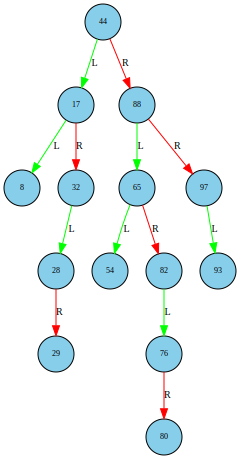

In [18]:
# Nodes are numbered starting 0
# Following list provides node values
nodes = [44,17,88,8,32,65,97,28,54,82,93,29,76,80]
# Edgelist - represented as tuple
# For example (0, 1) means an edge between node-0 (value=44) and node-1 (value=17)
edges = [(0,1), (0,2), (1,3), (1,4), (2, 5), (2, 6), (4,7), (5,8), (5,9), (6,10), (7,11), (9,12), (12,13)]
tree = Tree(nodes, edges)
draw_tree(svg_file='test_tree.svg', tree=tree)
show_svg('test_tree.svg')


Pydot could not generate the perfect layout for binary search tree. To differentiate between left and right branch I decided to color code as well put edge label.

In [19]:
print(tree.inorder())
print(tree.preorder())
print(tree.first())
print(tree.last())


[8, 17, 28, 29, 32, 44, 54, 65, 76, 80, 82, 88, 93, 97]
[44, 17, 8, 32, 28, 29, 88, 65, 54, 82, 76, 80, 97, 93]
8
97


### Find the node which appears before a given node in BST

In [21]:
for node_value in [82, 93, 8]:
    print("Node with value %s is before node with value %d" % (tree.before(node_value), node_value))


Node with value 80 is before node with value 82
Node with value 88 is before node with value 93
Node with value None is before node with value 8


### FInd  the node which appears after a given node in BST

In [22]:
for node_value in [32, 93, 97]:
    print("Node with value %s is after node with value %d" % (tree.before(node_value), node_value))
    

Node with value 29 is after node with value 32
Node with value 88 is after node with value 93
Node with value 93 is after node with value 97


### BST - insert node

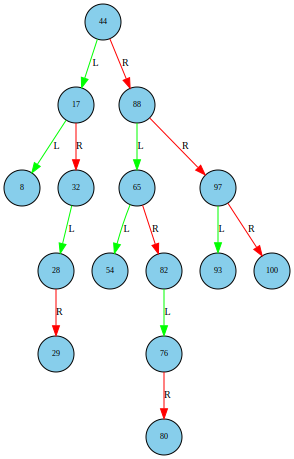

Node with value 100 is found
Node with maximum value = 100


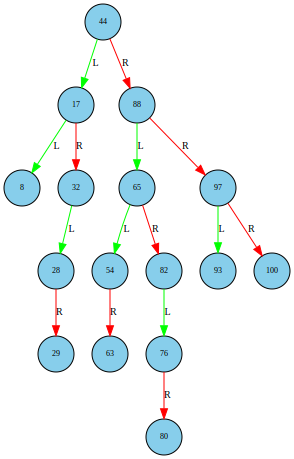

In [23]:
node_value = 100
tree.insert(node_value)
draw_tree(svg_file='test_tree.svg', tree=tree)
show_svg('test_tree.svg')
found_100 = tree.find_exact(value=node_value)
print("Node with value %d is%s found" % (node_value, '' if found_100 else ' not '))
print("Node with maximum value = %s" % tree.last())
tree.insert(63)
draw_tree(svg_file='test_tree.svg', tree=tree)
show_svg('test_tree.svg')

### Display tree from in-memory nodes

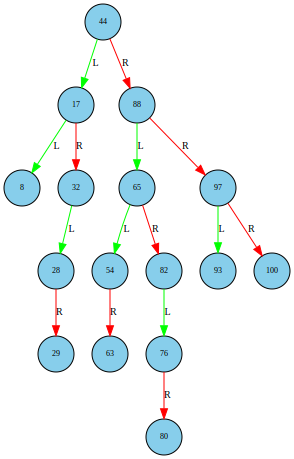

In [24]:
draw_tree(tree=tree, svg_file='test_tree.svg')
show_svg('test_tree.svg')

In [25]:
print(tree.root)

44


### BST - delete nodes

[44, 17, 88, 8, 32, 65, 97, 28, 54, 82, 93, 29, 63, 76, 80]


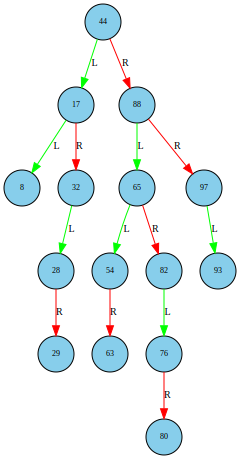

In [26]:
tree.delete(100)
n, e = tree.level_order_traversal()
print(n)
draw_tree(svg_file='test_tree.svg', nodes=n, edges=e)
show_svg('test_tree.svg')

[44, 17, 82, 8, 32, 65, 97, 28, 54, 76, 93, 29, 63, 80]


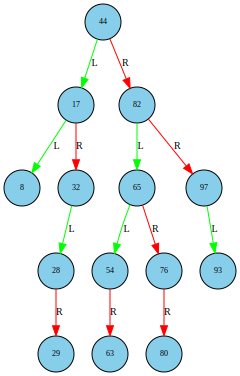

In [27]:
tree.delete(88)
n, e = tree.level_order_traversal(root=tree.root)
print(n)
draw_tree(svg_file='test_tree.svg', nodes=n, edges=e)
show_svg('test_tree.svg')

44
[44, 17, 82, 8, 32, 65, 97, 28, 54, 76, 93, 29, 63, 80]


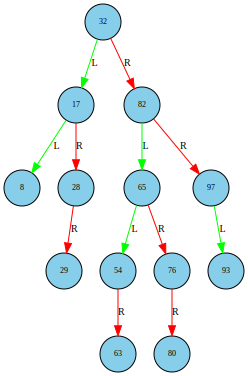

In [28]:
print(tree.root)
n, e = tree.level_order_traversal()
print(n)
tree.delete(44)
n, e = tree.level_order_traversal(tree.root)
draw_tree(nodes=n, edges=e, svg_file='test_tree.svg')
show_svg('test_tree.svg')

### Inserting deleted nodes

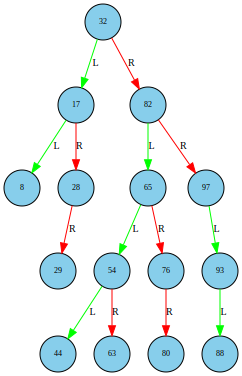

In [29]:
tree.insert(44)
tree.insert(88)
n, e = tree.level_order_traversal(tree.root)
draw_tree(nodes=n, edges=e, svg_file='test_tree.svg')
show_svg('test_tree.svg')

### Range search
First rebuild the original tree

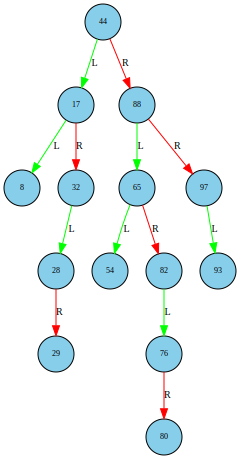

[32, 44, 54]

[28, 29, 32, 44, 54, 65, 76, 80, 82, 88, 93, 97]

In [30]:
tree = Tree(nodes, edges)
n, e = tree.level_order_traversal()
draw_tree(nodes=n, edges=e, svg_file='test_tree.svg')
show_svg('test_tree.svg')
tree.range_search(low=30, high=64)
tree.range_search(low=27, high=97)

## Building tree from inorder and postorder list of nodes

first we generate inorder and postorder for our example tree


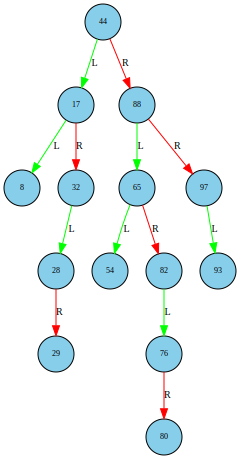

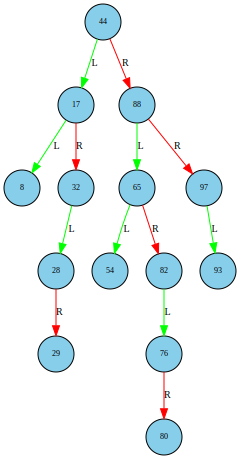

In [31]:
tree = Tree(nodes, edges)
n, e = tree.level_order_traversal()
draw_tree(tree=tree, svg_file='test_tree.svg')
show_svg('test_tree.svg')
new_tree = Tree(root=tree.build_tree_from_inorder_preorder(tree.inorder(), tree.preorder()))
draw_tree(tree=new_tree, svg_file='test_new_tree.svg')
show_svg('test_new_tree.svg')

### AVL Tree

Insertion in AVL tree works the same way as that of regular binary search tree. Node einsertion is followed by a balance stage. We don't need to keep any parent pointer as nodes are traversed in reverse order as it popped from stack while recursion unwinds.

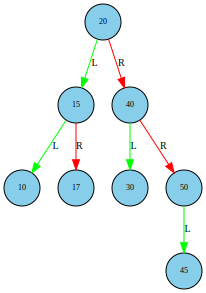

In [32]:
class AVLTreeNode(Node):
    def __init__(self, value, left=None, right=None, height=1):
        self.height = height
        super().__init__(value, left, right)
        
class AVLTree(Tree):
    def __init__(self, root=None):
        self.root = root
    
    def get_height(self, root):
        if root is None:
            return 0
        return max(self.get_height(root.left), self.get_height(root.right)) + 1
        
    def get_balance(self, root):
        if root is None:
            return 0
        else:
            return self.get_height(root.left) - self.get_height(root.right)
        
    def right_rotation(self, x):
        y = x.left
        x.left = y.right
        y.right = x
        x.height = self.get_height(x)
        y.height = self.get_height(y)
        return y

    def left_rotation(self, x):
        y = x.right
        x.right = y.left
        y.left = x
        x.height = self.get_height(x)
        y.height = self.get_height(y)
        return y
    
    def insert(self, root, value):
        if root is None:
            return AVLTreeNode(value)
        else:
            if root.value > value:
                root.left = self.insert(root.left, value)
            elif root.value < value:
                root.right = self.insert(root.right, value)
        root.height = self.get_height(root)
        balance = self.get_balance(root)
        if balance > 1:
            if value < root.left.value: #left-left case
                return self.right_rotation(root)
            elif value > roo.left.value: #left-right case
                root = self.left_rotation(root)
                return self.right_rotation(root)
        elif balance < -1:
            if value > root.right.value: #right-right case
                return self.left_rotation(root)
            elif value > root.right.value: # right-left case
                root = self.right_rotation(root)
                return self.left_rotation(root)
        return root
           
    def get_min_value_node(self, root):
        if root is None or root.left is None:
            return root
        else:
            return self.get_min_value_node(root.left)
        
    def delete(self, root, value):
        if root is None:
            return root
        else:
            if root.value > value:
                root.left = self.delete(root.left, value)
            elif root.value < value:
                root.right = self.delete(root.right, value)
            else:
                if root.left is None:
                    temp = root.right
                    root = None
                    return temp
                elif root.right is None:
                    temp = root.left
                    root = None
                    return temp
                else:
                    temp = self.get_min_value_node(root.right)
                    root.value = temp.value
                    root.right = self.delete(root.right, temp.value)
        root.height = self.get_height(root)
        balance = self.get_balance(root)
        if balance > 1:
            if self.get_balance(root.left) >= 0: #left-left case
                return self.right_rotation(root)
            elif self.get_balance(root.left) < 0: #left-right case
                root.left = self.left_rotation(root.left)
                return self.right_rotation(root)
        elif balance < -1:
            if self.get_balance(root.right) <= 0: #right-right case
                return self.left_rotation(root)
            elif self.get_balance(root.right) > 0: # right-left case
                root.right = self.right_rotation(root.right)
                return self.left_rotation(root)
        return root

    
avl_tree = AVLTree()
for i in [30, 20, 10, 40, 50, 15, 17, 45]:
    avl_tree.root = avl_tree.insert(avl_tree.root, i)
draw_tree(tree=avl_tree, svg_file='avl_tree.svg')
show_svg('avl_tree.svg')

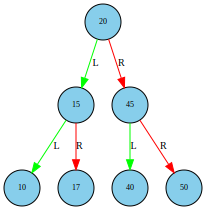

In [33]:
avl_tree = AVLTree()
for i in [30, 20, 10, 40, 50, 15, 17, 45]:
    avl_tree.root = avl_tree.insert(avl_tree.root, i)
avl_tree.root = avl_tree.delete(avl_tree.root, 30)
draw_tree(tree=avl_tree, svg_file='avl_tree.svg')
show_svg('avl_tree.svg')

### Splay tree

In [34]:
class Node:
    def __init__(self, value):
        self.value = value
        self.left = None
        self.right = None
        self.sum = value
        
    def update(self):
        self.sum = self.value + (self.left.sum if self.left is not None else 0) + (self.right.sum if self.right is not None else 0)
        
    def __str__(self):
        return '(' + str(self.value) + ' ' + str(self.sum) + ')'
    
class SplayTree(Tree):
    def __init__(self, root=None):
        self.root = root

    def delete(self, root, value):
        if root is None: 
            return root
        k = self.splay(root, value)
        if k.value != value:
            return k
        if k.left is None:
            return k.right
        else:
            temp = k
            new_root = self.splay(k.left, value)
            new_root.right = temp.right
            temp = None
            return new_root
        
    def search(self, root, value):
        return self.splay(root, value)
    
    def insert(self, root, value):
        if root is None:
            return Node(value)
        else:
            # Splaying the tree will bring the node having given key to the root
            # If one such exists, then no action needs to be taken 
            # If such node doesn't exist then splay operation will bring up 
            # the node before or after the value to be inserted
            root = self.splay(root, value)
            n = Node(value)
            if root.value == value:
                return root
            # If it returned the value following the given key then
            # Put the left subtree of current root as left subtree of the newly created node
            elif root.value > value:
                n.right = root
                n.left = root.left
                root.left = None
                root.update()
                n.update()
                return n
            elif root.value < value:
                n.left = root
                n.right = root.right
                root.right = None
                root.update()
                n.update()
                return n
                

    def left_rotate(self, gp):
        p = gp.right
        gp.right = p.left
        p.left = gp
        gp.update()
        p.update()
        return p

    def right_rotate(self, gp):
        p = gp.left 
        gp.left = p.right
        p.right = gp
        gp.update()
        p.update()
        return p
    
    def merge(self, left, right):
        if left is None:
            return right
        if right is None: 
            return left
        right_root = right
        while right.left is not None:
            right = right.left
        right_root = self.splay(right_root, right.value)
        right_root.left = left
        right_root.update()
        return right_root
    
    def range_sum(self, root, low, high):
        result = 0
        root = self.splay(root, low)
        if root.value >= low and root.value <= high:
            result += root.value
        if root.right is not None:
            root.right = self.splay(root.right, high)
            if root.right.value >= low and root.right.value <= high:
                result += root.right.value
            if root.right.left is not None:
                result += root.right.left.sum
        self.root = root
        return result

    def splay(self, root, value):
        # Either the root is empty or value already exists as roo
        if root is None or root.value == value:
            return root
        elif root.value > value: # reach for left subtree
            if root.left is None:
                # value is not present in the tree
                return root
            if root.left.value > value:
                # This will bubble up value node as root.left.left
                root.left.left = self.splay(root.left.left, value)
                root = self.right_rotate(root)
            elif root.left.value < value: # Zig Zag (left right case)
                root.left.right = self.splay(root.left.right, value)
                if root.left.right is not None:
                    root.left = self.left_rotate(root.left)
            return root if root.left is None else self.right_rotate(root)
        else:
            if root.right is None:
                return root
            if root.right.value > value:
                root.right.left = self.splay(root.right.left, value)
                if root.right.left is not None:
                    root.right = self.right_rotate(root.right)
            elif root.right.value < value:
                root.right.right = self.splay(root.right.right, value)
                root = self.left_rotate(root)
            return root if root.right is None else self.left_rotate(root)



### Merging two splay trees

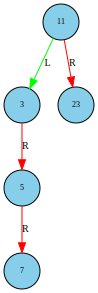

(11 49)


In [35]:
left = None
left_splay_tree = SplayTree(left)
for v in [7, 5, 3]:
    left = left_splay_tree.insert(left, v)
right = None
right_splay_tree = SplayTree(right)
for v in [11, 23]:
    right = right_splay_tree.insert(right, v)
root = None
merged_splay_tree = SplayTree(root)
merged_splay_tree.root = merged_splay_tree.merge(left, right)
draw_tree(tree=merged_splay_tree, svg_file='merged_splay_tree.svg')
show_svg('merged_splay_tree.svg')
print(merged_splay_tree.root)

### Range search in the above merged tree

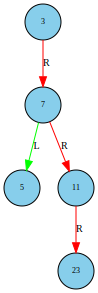

(3 49) 8


In [36]:
result = merged_splay_tree.range_sum(merged_splay_tree.root, 2, 6)
draw_tree(tree=merged_splay_tree, svg_file='merged_splay_tree.svg')
show_svg('merged_splay_tree.svg')
print(merged_splay_tree.root, result)

### Building a new splay tree by node insertion

(7 49) (5 8) (11 34)


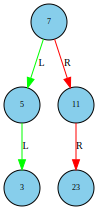

In [37]:
root = None
splay_tree = SplayTree(root)
for v in [5, 7, 3, 11, 23, 7]:
    root = splay_tree.insert(root, v)
splay_tree.root = root
print(root, root.left, root.right)
draw_tree(tree=splay_tree, svg_file='splay_tree.svg')
show_svg('splay_tree.svg')

### Search for a value which does not exist

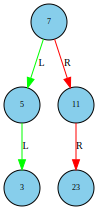

In [39]:
root = splay_tree.search(root, 6)
splay_tree.root = root
draw_tree(tree=splay_tree, svg_file='splay_tree_1.svg')
show_svg('splay_tree_1.svg')


### Searching for a number that exists in the tree

Splay operation brings that number to the top.

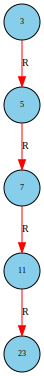

In [42]:
splay_tree.root = splay_tree.search(splay_tree.root, 3)
draw_tree(tree=splay_tree, svg_file='splay_tree.svg')
show_svg('splay_tree.svg')

### Generating a random splay and test range sum

First to calculate the expected range sum by brute force method so that it can be matched with the sum coming back from Splay tree.

In [46]:
import random
root = None
splay_tree = SplayTree(root)

values = []

count = 40
for i in range(0,count):
    x = random.randint(1,100)
    if x not in values:
        values.append(x)
        
low = random.randint(1, 100)
high = random.randint(low, 100)
expected_sum = sum([v for v in values if v >= low and v <= high])
print('range = %d - %d, sum = %d' % (low, high, expected_sum))
for value in values:
    root = splay_tree.insert(root, value)


range = 57 - 80, sum = 522


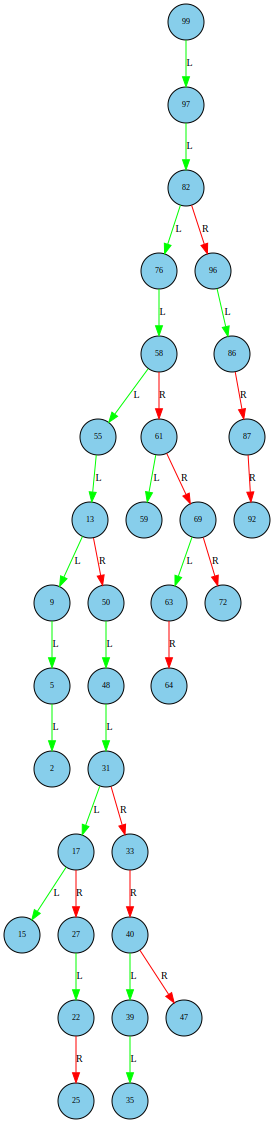

In [47]:
splay_tree.root = root
draw_tree(tree=splay_tree, svg_file='splay_tree.svg')
show_svg('splay_tree.svg')



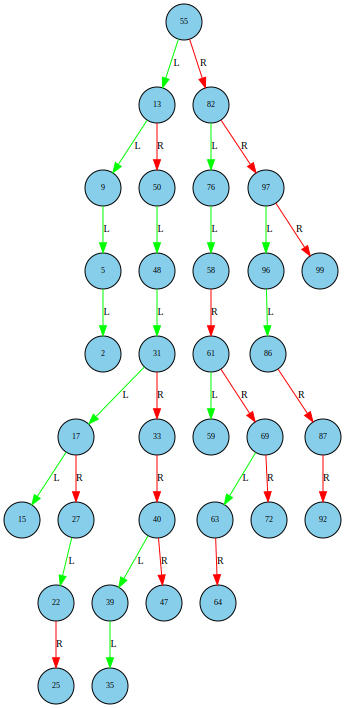

(55 1674) 522


In [48]:
result = splay_tree.range_sum(splay_tree.root, low, high)
draw_tree(tree=splay_tree, svg_file='splay_tree.svg')
show_svg('splay_tree.svg')
print(splay_tree.root, result)

**Range sum matches**

### Delete node from splay tree

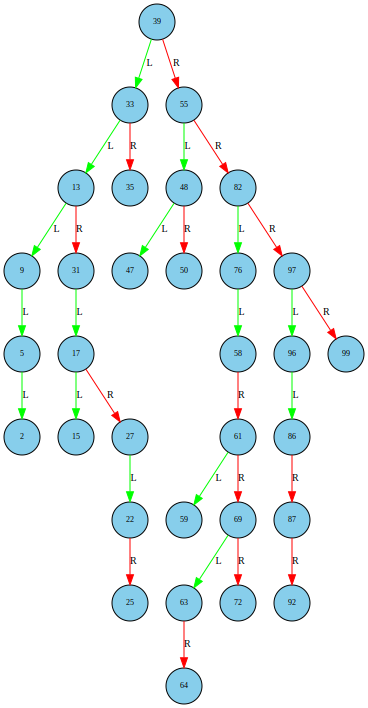

In [49]:
splay_tree.root = splay_tree.delete(splay_tree.root, 40)
draw_tree(tree=splay_tree, svg_file='splay_tree.svg')
show_svg('splay_tree.svg')